# Making predictions with BlazeFace

This notebook shows how to use the model for face detection.

In [1]:
import numpy as np
import torch
import cv2

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
print("PyTorch version:", torch.__version__)
print("CUDA version:", torch.version.cuda)
print("cuDNN version:", torch.backends.cudnn.version())

PyTorch version: 2.0.1
CUDA version: None
cuDNN version: None


In [3]:
gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
gpu

device(type='cpu')

Helper code for making plots:

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_detections(img, detections, with_keypoints=True):
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.grid(False)
    ax.imshow(img)
    
    if isinstance(detections, torch.Tensor):
        detections = detections.cpu().numpy()

    if detections.ndim == 1:
        detections = np.expand_dims(detections, axis=0)

    print("Found %d faces" % detections.shape[0])
        
    for i in range(detections.shape[0]):
        ymin = detections[i, 0] * img.shape[0]
        xmin = detections[i, 1] * img.shape[1]
        ymax = detections[i, 2] * img.shape[0]
        xmax = detections[i, 3] * img.shape[1]

        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                 linewidth=1, edgecolor="r", facecolor="none", 
                                 alpha=detections[i, 16])
        ax.add_patch(rect)

        if with_keypoints:
            for k in range(6):
                kp_x = detections[i, 4 + k*2    ] * img.shape[1]
                kp_y = detections[i, 4 + k*2 + 1] * img.shape[0]
                circle = patches.Circle((kp_x, kp_y), radius=0.5, linewidth=1, 
                                        edgecolor="lightskyblue", facecolor="none", 
                                        alpha=detections[i, 16])
                ax.add_patch(circle)
        
    plt.show()

## Load the front and back models

In [5]:
from blazeface_onnx import BlazeFace

front_net = BlazeFace().to(gpu)
front_net.load_weights("onnx/face_detection_front_128x128_float32.onnx")
front_net.load_anchors("anchors.npy")

# Optionally change the thresholds:
front_net.min_score_thresh = 0.75
front_net.min_suppression_threshold = 0.3

/Users/tobyclh/opt/anaconda3/envs/fcs_dev/lib/python3.9/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:65: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'CPUExecutionProvider'
  warnings.warn(


## Make a prediction

The input image should be 128x128 for the front model and 256x256 for the back model. BlazeFace will not automatically resize the image, you have to do this yourself!

In [19]:
img = cv2.imread("1face.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [20]:
front_detections = front_net.predict_on_image(img)
front_detections.shape

torch.Size([1, 17])

In [21]:
front_detections

tensor([[0.2763, 0.3182, 0.4465, 0.4884, 0.3830, 0.3150, 0.4561, 0.3202, 0.4309,
         0.3526, 0.4229, 0.3913, 0.3182, 0.3373, 0.4769, 0.3464, 0.9308]])

Found 1 faces


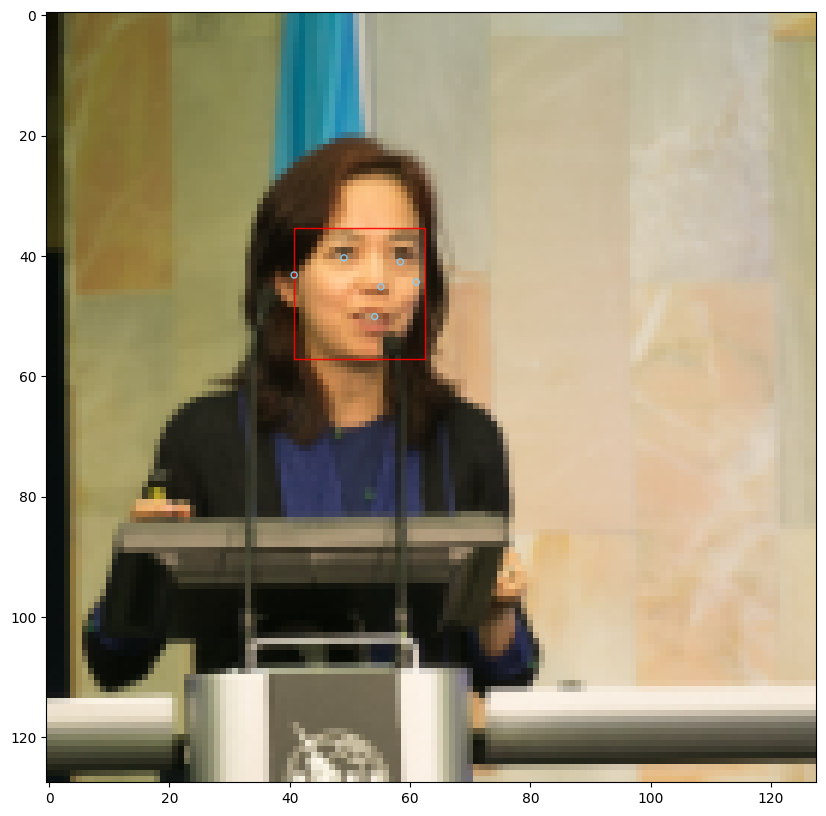

In [22]:
plot_detections(img, front_detections)

In [10]:
img2 = cv2.resize(img, (256, 256))
back_detections = back_net.predict_on_image(img2)
back_detections.shape

NameError: name 'back_net' is not defined

In [ ]:
back_detections

tensor([[0.2729, 0.3162, 0.4527, 0.4960, 0.3873, 0.3154, 0.4597, 0.3212, 0.4349,
         0.3587, 0.4272, 0.3989, 0.3224, 0.3346, 0.4797, 0.3432, 0.8783]])

Found 1 faces


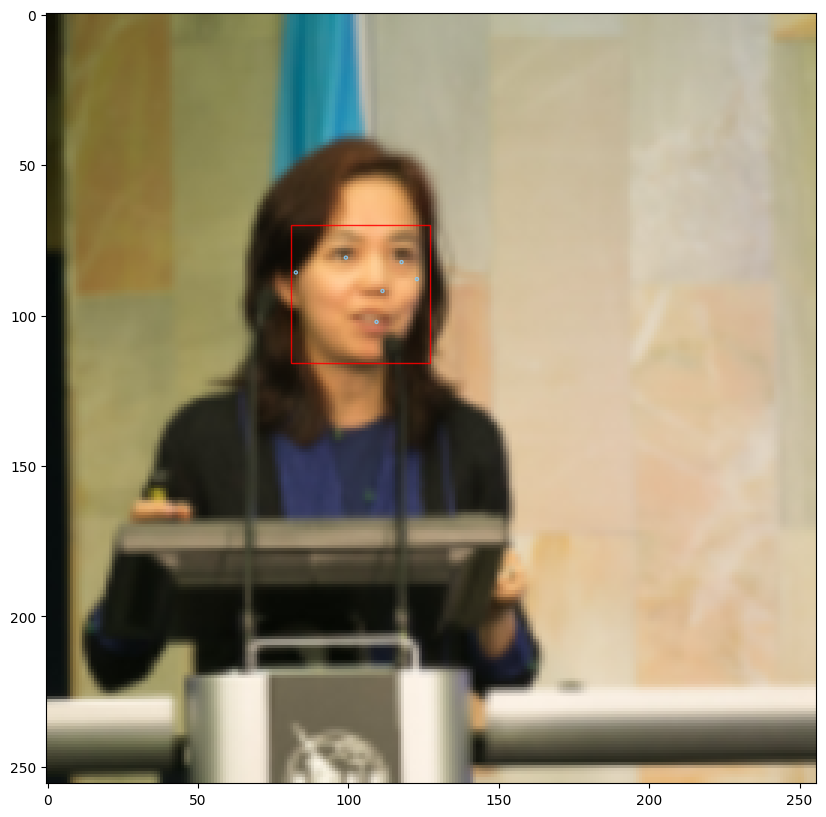

In [ ]:
plot_detections(img2, back_detections)

## Make prediction on a batch of images

Load the images into a NumPy array of size `(batch, 128, 128, 3)` for front model or of size `(batch, 256, 256, 3)` for back model. Note: You could also use a PyTorch tensor here, in which case the shape must be `(batch, 3, 128, 128)` or `(batch, 3, 256, 256)`.

In [11]:
filenames = [ "1face.png", "3faces.png", "4faces.png" ]

xfront = np.zeros((len(filenames), 128, 128, 3), dtype=np.uint8)
xback = np.zeros((len(filenames), 256, 256, 3), dtype=np.uint8)

for i, filename in enumerate(filenames):
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    xfront[i] = img
    xback[i] = cv2.resize(img, (256, 256))

In [23]:
front_detections = front_net.predict_on_batch(xfront)
[d.shape for d in front_detections]

InvalidArgument: [ONNXRuntimeError] : 2 : INVALID_ARGUMENT : Got invalid dimensions for input: input:0 for the following indices
 index: 0 Got: 3 Expected: 1
 Please fix either the inputs or the model.

In [ ]:
front_detections

[tensor([[0.2714, 0.3171, 0.4416, 0.4873, 0.3863, 0.3127, 0.4613, 0.3186, 0.4400,
          0.3557, 0.4328, 0.3915, 0.3154, 0.3296, 0.4778, 0.3367, 0.9960]]),
 tensor([[0.3443, 0.0852, 0.4834, 0.2244, 0.1335, 0.3838, 0.1981, 0.3769, 0.1788,
          0.4125, 0.1769, 0.4428, 0.0832, 0.4031, 0.2211, 0.3888, 0.9991],
         [0.3270, 0.7762, 0.4765, 0.9256, 0.8064, 0.3708, 0.8683, 0.3571, 0.8276,
          0.3952, 0.8355, 0.4299, 0.7934, 0.3984, 0.9291, 0.3740, 0.9968],
         [0.3454, 0.4172, 0.4805, 0.5523, 0.4581, 0.3886, 0.5141, 0.3864, 0.4884,
          0.4244, 0.4891, 0.4475, 0.4259, 0.3933, 0.5457, 0.3888, 0.9245]]),
 tensor([], size=(0, 17))]

Found 1 faces


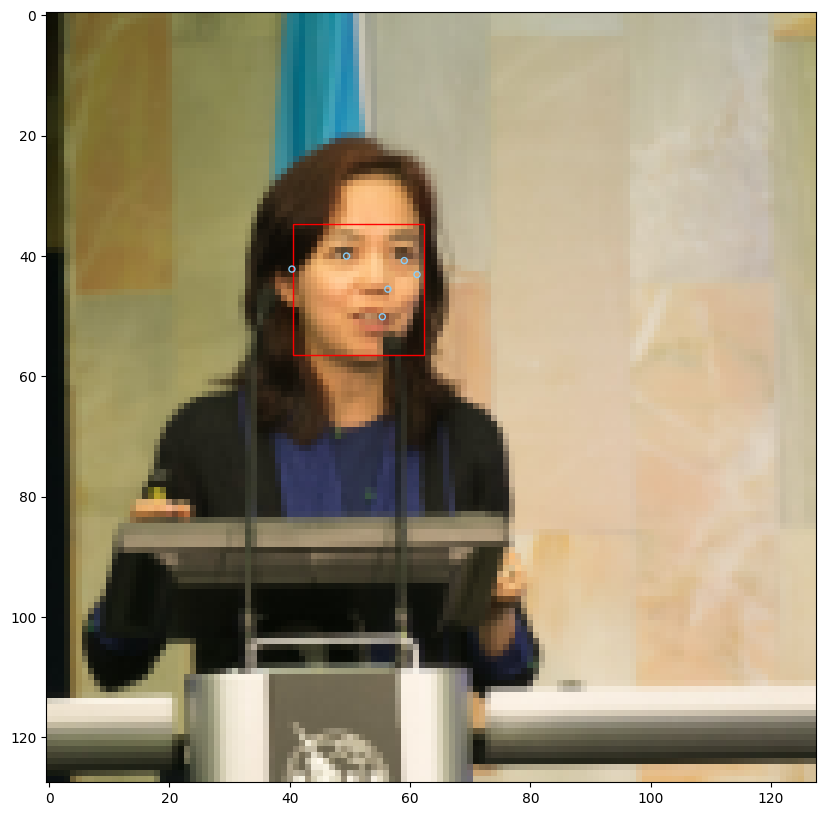

In [ ]:
plot_detections(xfront[0], front_detections[0])

Found 3 faces


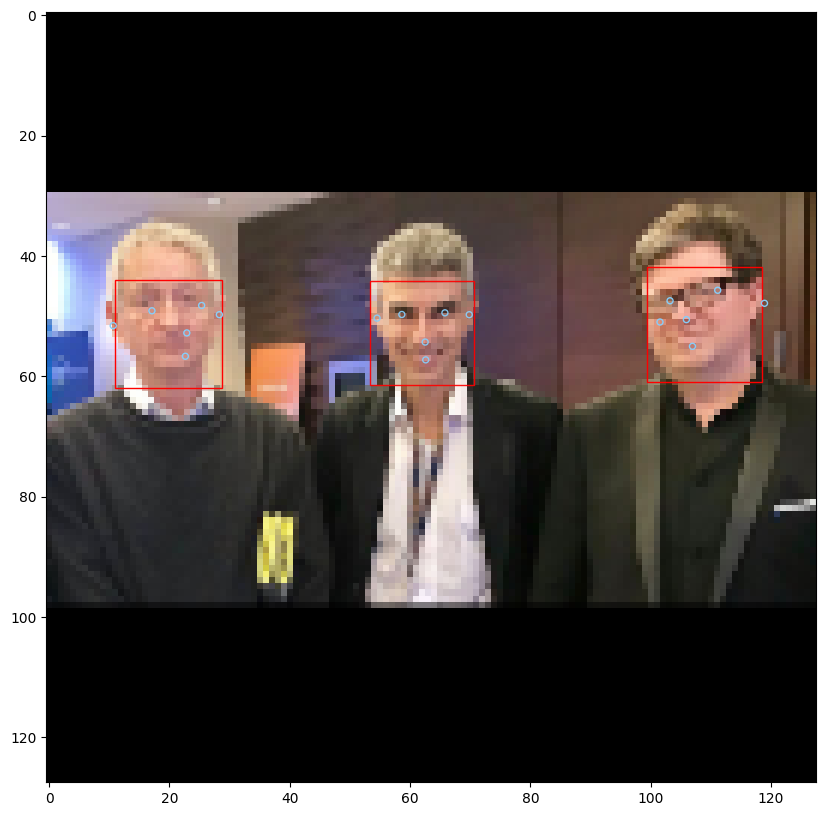

In [ ]:
plot_detections(xfront[1], front_detections[1])

Found 0 faces


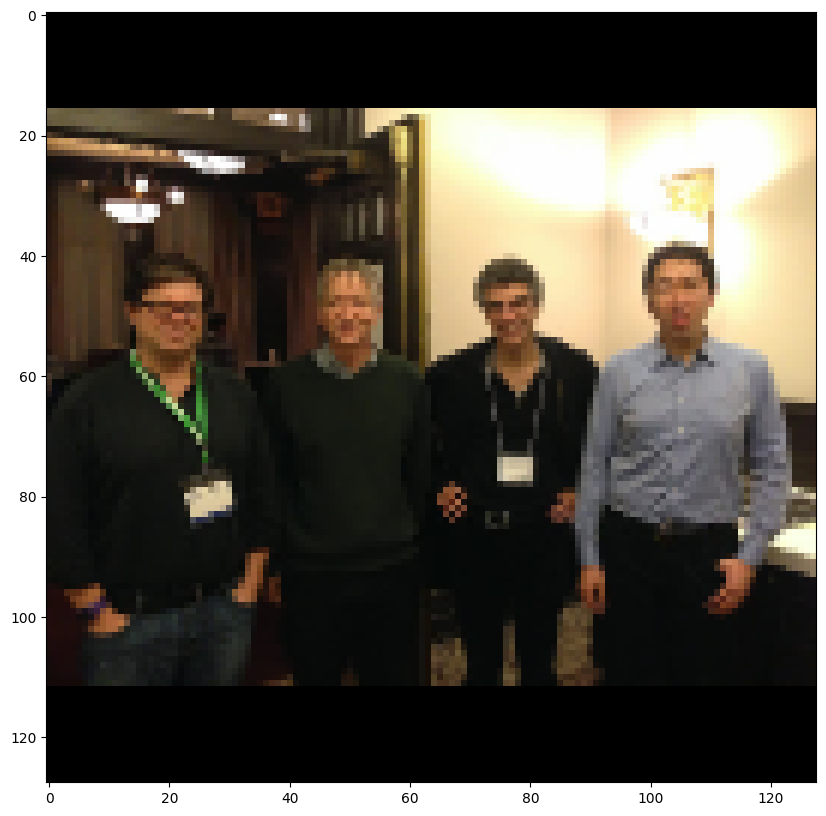

In [ ]:
plot_detections(xfront[2], front_detections[2])

In [ ]:
back_detections = back_net.predict_on_batch(xback)
[d.shape for d in back_detections]

[torch.Size([1, 17]), torch.Size([3, 17]), torch.Size([3, 17])]

In [ ]:
back_detections

[tensor([[0.2729, 0.3162, 0.4527, 0.4960, 0.3873, 0.3154, 0.4597, 0.3212, 0.4349,
          0.3587, 0.4272, 0.3989, 0.3224, 0.3346, 0.4797, 0.3432, 0.8783]]),
 tensor([[0.3509, 0.4300, 0.4777, 0.5568, 0.4627, 0.3937, 0.5174, 0.3916, 0.4888,
          0.4293, 0.4912, 0.4488, 0.4368, 0.3943, 0.5521, 0.3893, 0.8168],
         [0.3336, 0.7804, 0.4642, 0.9109, 0.8029, 0.3691, 0.8574, 0.3636, 0.8212,
          0.3935, 0.8284, 0.4229, 0.7916, 0.3877, 0.9104, 0.3778, 0.8559],
         [0.3393, 0.0909, 0.4737, 0.2252, 0.1293, 0.3777, 0.1876, 0.3743, 0.1611,
          0.4077, 0.1627, 0.4354, 0.0957, 0.3924, 0.2201, 0.3842, 0.8399]]),
 tensor([[0.3421, 0.7887, 0.4160, 0.8626, 0.8104, 0.3593, 0.8421, 0.3600, 0.8255,
          0.3739, 0.8248, 0.3912, 0.7909, 0.3701, 0.8603, 0.3726, 0.8175],
         [0.3601, 0.5668, 0.4355, 0.6423, 0.5852, 0.3846, 0.6158, 0.3813, 0.6006,
          0.4000, 0.6036, 0.4140, 0.5722, 0.3899, 0.6393, 0.3819, 0.8296],
         [0.3404, 0.1093, 0.4500, 0.2188, 0.1403, 0.38

Found 1 faces


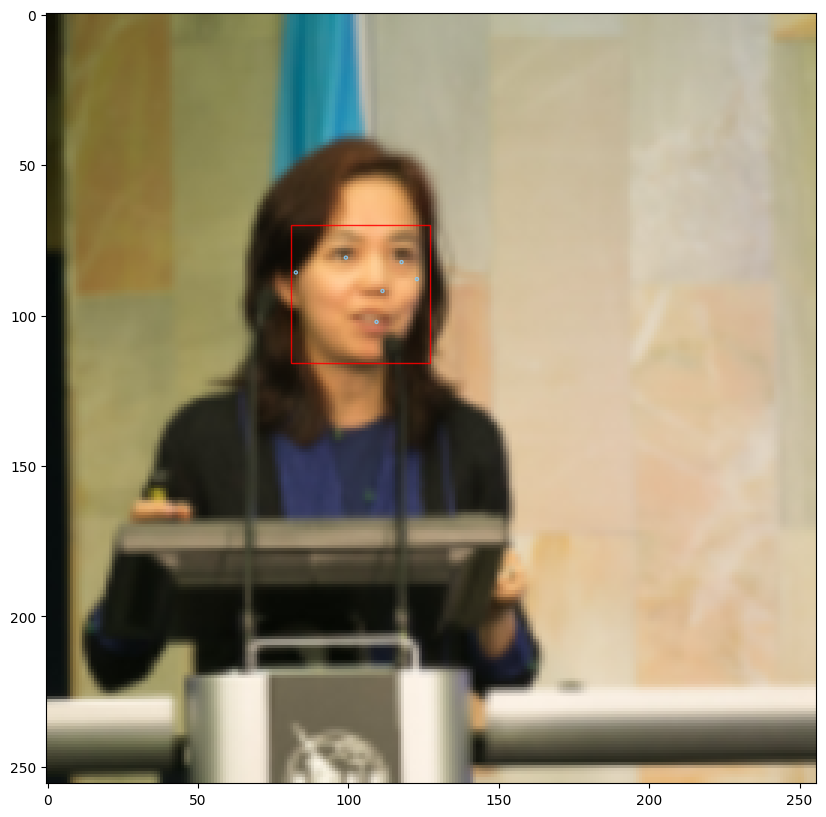

In [ ]:
plot_detections(xback[0], back_detections[0])

Found 3 faces


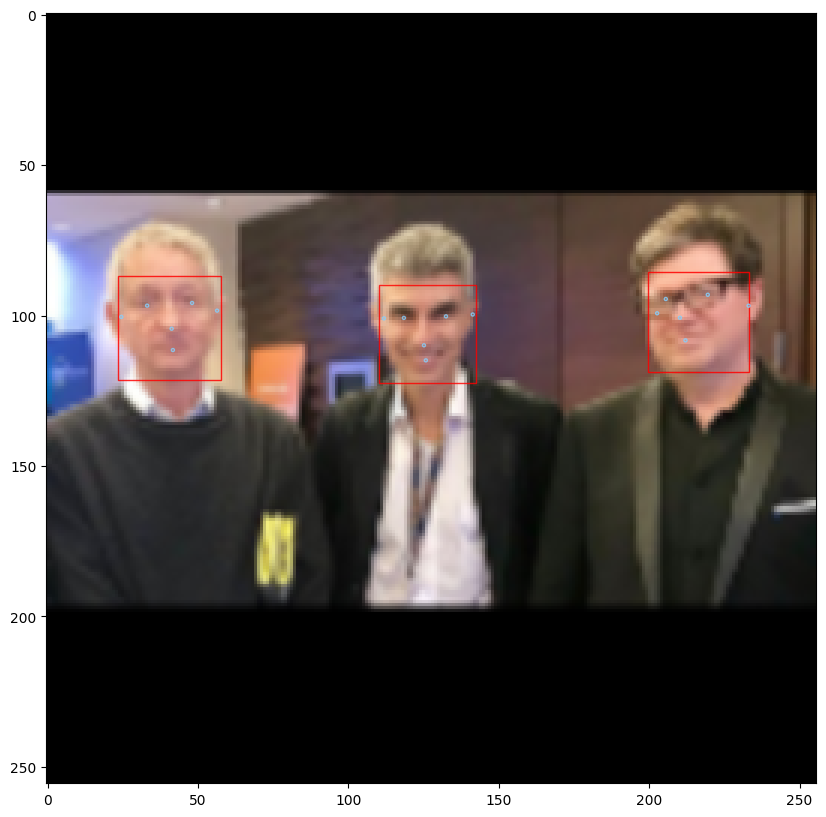

In [ ]:
plot_detections(xback[1], back_detections[1])

Found 3 faces


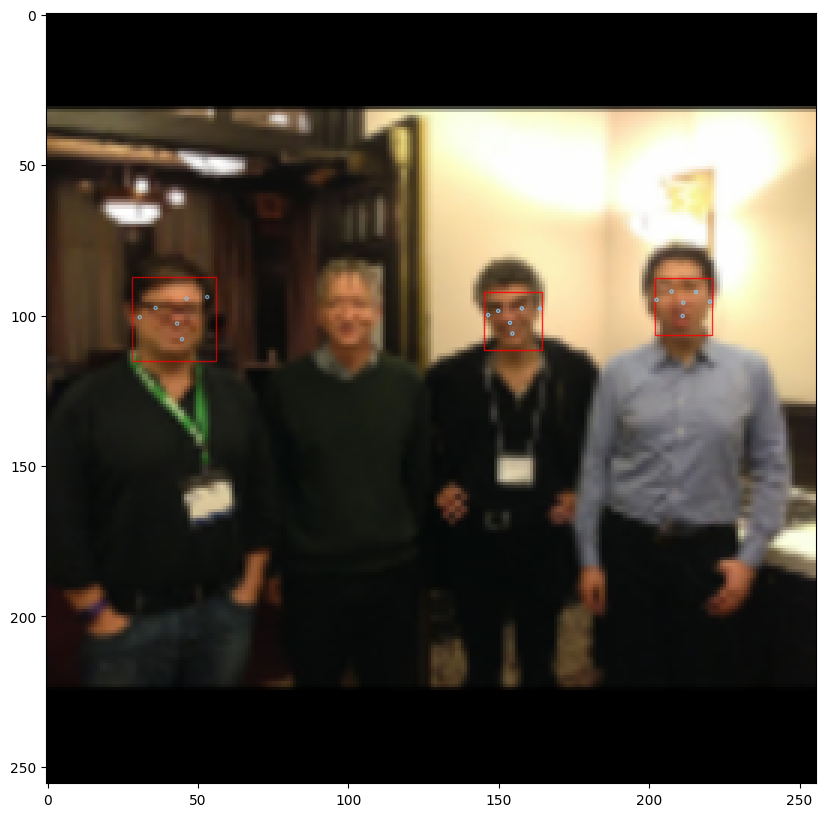

In [ ]:
plot_detections(xback[2], back_detections[2])